<a href="https://colab.research.google.com/github/OtusTeam/Machine-Learning/blob/main/%D0%9C%D0%BE%D0%B4%D1%83%D0%BB%D1%8C%207%3A%20Bayesian%20Learning%2C%20PyMC/39_BBN_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pybbn
!sudo apt-get install graphviz graphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubunt

In [ ]:
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

In [ ]:
# create the nodes
season = BbnNode(Variable(0, 'season', ['winter', 'summer']), [0.5, 0.5])
atmos_pres = BbnNode(Variable(1, 'atmos_press', ['high', 'low']), [0.5, 0.5])
allergies = BbnNode(Variable(2, 'allergies', ['allergic', 'non_alergic']), [0.7, 0.3, 0.2, 0.8])
rain = BbnNode(Variable(3, 'rain', ['rainy', 'sunny']), [0.9, 0.1, 0.7, 0.3, 0.3, 0.7, 0.1, 0.9])
grass = BbnNode(Variable(4, 'grass', ['grass', 'no_grass']), [0.8, 0.2, 0.3, 0.7])
umbrellas = BbnNode(Variable(5, 'umbrellas', ['on', 'off']), [0.99, 0.01, 0.80, 0.20, 0.20, 0.80, 0.01, 0.99])
dog_bark = BbnNode(Variable(6, 'dog_bark', ['bark', 'not_bark']), [0.8, 0.2, 0.1, 0.9])
cat_mood = BbnNode(Variable(7, 'cat_mood', ['good', 'bad']), [0.05, 0.95, 0.95, 0.05])
cat_hide = BbnNode(Variable(8, 'cat_hide', ['hide', 'show']), [0.20, 0.80, 0.95, 0.05, 0.95, 0.05, 0.70, 0.30])

bbn = Bbn() \
    .add_node(season) \
    .add_node(atmos_pres) \
    .add_node(allergies) \
    .add_node(rain) \
    .add_node(grass) \
    .add_node(umbrellas) \
    .add_node(dog_bark) \
    .add_node(cat_mood) \
    .add_node(cat_hide) \
    .add_edge(Edge(season, allergies, EdgeType.DIRECTED)) \
    .add_edge(Edge(season, umbrellas, EdgeType.DIRECTED)) \
    .add_edge(Edge(season, rain, EdgeType.DIRECTED)) \
    .add_edge(Edge(atmos_pres, rain, EdgeType.DIRECTED)) \
    .add_edge(Edge(rain, grass, EdgeType.DIRECTED)) \
    .add_edge(Edge(rain, umbrellas, EdgeType.DIRECTED)) \
    .add_edge(Edge(rain, dog_bark, EdgeType.DIRECTED)) \
    .add_edge(Edge(rain, cat_mood, EdgeType.DIRECTED)) \
    .add_edge(Edge(dog_bark, cat_hide, EdgeType.DIRECTED)) \
    .add_edge(Edge(cat_mood, cat_hide, EdgeType.DIRECTED))

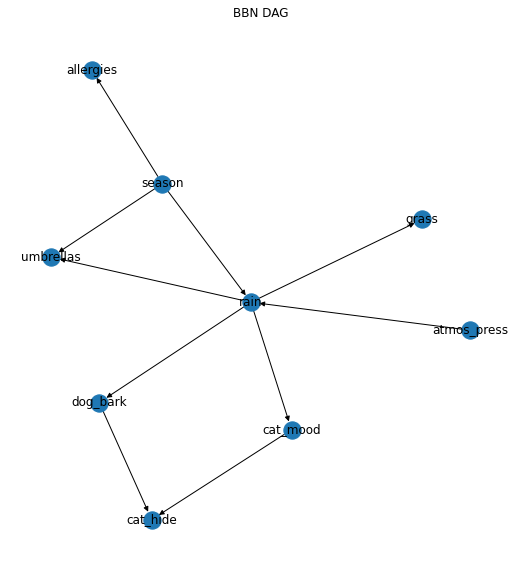

In [ ]:
%matplotlib inline
from pybbn.generator.bbngenerator import convert_for_drawing
import matplotlib.pyplot as plt
import networkx as nx
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    graph = convert_for_drawing(bbn)
    pos = nx.nx_agraph.graphviz_layout(graph, prog='neato')

    plt.figure(figsize=(20, 10))
    plt.subplot(121) 
    labels = dict([(k, node.variable.name) for k, node in bbn.nodes.items()])
    nx.draw(graph, pos=pos, with_labels=True, labels=labels)
    plt.title('BBN DAG')

In [ ]:
# convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

# insert an observation evidence
ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name('season')) \
    .with_evidence('winter', 1.0) \
    .build()

join_tree.set_observation(ev)

# print the marginal probabilities
for node in join_tree.get_bbn_nodes():
    potential = join_tree.get_bbn_potential(node)
    print(node)
    print(potential)
    print('--------------------->')

0|season|winter,summer
0=winter|1.00000
0=summer|0.00000
--------------------->
2|allergies|allergic,non_alergic
2=allergic|0.70000
2=non_alergic|0.30000
--------------------->
3|rain|rainy,sunny
3=rainy|0.80000
3=sunny|0.20000
--------------------->
4|grass|grass,no_grass
4=grass|0.70000
4=no_grass|0.30000
--------------------->
1|atmos_press|high,low
1=high|0.50000
1=low|0.50000
--------------------->
5|umbrellas|on,off
5=on|0.95200
5=off|0.04800
--------------------->
6|dog_bark|bark,not_bark
6=bark|0.66000
6=not_bark|0.34000
--------------------->
7|cat_mood|good,bad
7=good|0.23000
7=bad|0.77000
--------------------->
8|cat_hide|hide,show
8=hide|0.87150
8=show|0.12850
--------------------->
